In [1]:
%matplotlib inline
import os

import cftime

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

# NOTE: issues in esmlab are being actively fixed, so using local install instead of release version
import esmlab

import intake
# NOTE: installed from master because last released version is buggy
import intake_esm

In [2]:
cesm2 = intake.open_esm_datastore('/glade/work/mlevy/CMIP6-CESM2_only-NOT_CMORIZED.json')
cesm2.df.head()

,experiment,case,component,stream,variable,date_range,member_id,path,year_offset
0,esm-piControl,b.e21.B1850.f09_g17.CMIP6-esm-piControl.001,atm,cam.h1,ACTNL,00010101-00101231,0,/glade/collections/cdg/timeseries-cmip6/b.e21....,NaN
1,esm-piControl,b.e21.B1850.f09_g17.CMIP6-esm-piControl.001,atm,cam.h1,ACTNL,00110101-00201231,0,/glade/collections/cdg/timeseries-cmip6/b.e21....,NaN
2,esm-piControl,b.e21.B1850.f09_g17.CMIP6-esm-piControl.001,atm,cam.h1,ACTNL,00210101-00301231,0,/glade/collections/cdg/timeseries-cmip6/b.e21....,NaN
3,esm-piControl,b.e21.B1850.f09_g17.CMIP6-esm-piControl.001,atm,cam.h1,ACTNL,00310101-00401231,0,/glade/collections/cdg/timeseries-cmip6/b.e21....,NaN
4,esm-piControl,b.e21.B1850.f09_g17.CMIP6-esm-piControl.001,atm,cam.h1,ACTNL,00410101-00501231,0,/glade/collections/cdg/timeseries-cmip6/b.e21....,NaN


In [3]:
cesm2.df.columns

Index(['experiment', 'case', 'component', 'stream', 'variable', 'date_range',
       'member_id', 'path', 'year_offset'],
      dtype='object')

In [ ]:
cmip5 = intake.open_esm_datastore('/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip5.json')
cesm1 = cmip5.search(model='CESM1-BGC')
cesm1.df.head()

In [4]:
keep_vars = ['TAREA', 'TLONG', 'TLAT', 'IRON_FLUX', 'time', 'time_bound', 'member_id']

In [5]:
# WORKAROUND FOR intake-esm ISSUE: limit to members with only a single file

cat = cesm2.search(experiment=['historical'], variable='IRON_FLUX')
cat.df.set_index(['member_id', 'date_range'])['path']

member_id  date_range   
1          185001-201412    /glade/collections/cdg/timeseries-cmip6/b.e21....
2          185001-201412    /glade/collections/cdg/timeseries-cmip6/b.e21....
3          185001-201412    /glade/collections/cdg/timeseries-cmip6/b.e21....
4          185001-201412    /glade/collections/cdg/timeseries-cmip6/b.e21....
5          185001-201412    /glade/collections/cdg/timeseries-cmip6/b.e21....
6          185001-201412    /glade/collections/cdg/timeseries-cmip6/b.e21....
7          185001-189912    /glade/collections/cdg/timeseries-cmip6/b.e21....
           190001-194912    /glade/collections/cdg/timeseries-cmip6/b.e21....
           195001-199912    /glade/collections/cdg/timeseries-cmip6/b.e21....
           200001-201412    /glade/collections/cdg/timeseries-cmip6/b.e21....
8          185001-189912    /glade/collections/cdg/timeseries-cmip6/b.e21....
           190001-194912    /glade/collections/cdg/timeseries-cmip6/b.e21....
           195001-199912    /glade/coll

In [6]:
# TODO: eventually we should be able to remove the member_id from the search
#dq = cesm2.search(experiment=['historical'], variable='IRON_FLUX', member_id=[1,2,3,4,5,6]).to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}, 'decode_times' : False})
#dq = cesm2.search(experiment=['historical'], variable='IRON_FLUX', member_id=[1,2,3,4,5,6]).to_dataset_dict(cdf_kwargs={'decode_times' : False})
dq = cesm2.search(experiment=['historical'], variable='IRON_FLUX', member_id=[1,2,3,4,5,6]).to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}})
#dq = cesm2.search(experiment=['historical'], variable='IRON_FLUX', member_id=[1,2,3,4,5,6]).to_dataset_dict()

_, ds2 = dq.popitem()
ds2 = ds2.drop([v for v in ds2.variables if v not in keep_vars])
ds2

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)


<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 6, nlat: 384, nlon: 320, time: 1980)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6
  * time        (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    time_bound  (time, d2) object dask.array<chunksize=(48, 2), meta=np.ndarray>
    IRON_FLUX   (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 48, 384, 320), meta=np.ndarray>
Attributes:
    contents:          Diagnostic and Prognostic Variables
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    sou

In [ ]:
dq = cesm1.search(experiment='historical', variable='IRON_FLUX').to_xarray(chunks={'time': 48})
_, ds1 = dq.popitem()
ds1 = ds1.drop([v for v in ds1.variables if v not in keep_vars])
ds1

In [7]:
ds2_ann = esmlab.resample(ds2, freq='ann')
ds2_ann

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 6, nlat: 384, nlon: 320, time: 165, year: 165)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6
    time        (year) object 1850-07-01 17:05:00 ... 2014-07-01 17:00:00
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (d2, time) object 1850-01-01 02:00:00 ... 2015-01-01 00:00:00
    IRON_FLUX   (member_id, time, nlat, nlon) float64 dask.array<chunksize=(1, 1, 384, 320), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Attributes:
    history:  \n2019-10-24 19:08:21.279836 esmlab.resample(<DATASET>, freq="a...

In [ ]:
ds1_ann = esmlab.resample(ds1, freq='ann')
ds1_ann

In [8]:
iron_flux_glb2 = esmlab.weighted_sum(ds2_ann.IRON_FLUX, dim=['nlat', 'nlon'], weights=ds2_ann.TAREA)
iron_flux_glb2 = iron_flux_glb2 * 1.0e-16 * 365.0 * 86400.0 # mmolFe/m^2/s to GmolFe/y
iron_flux_glb2.attrs['units'] = 'Gmol Fe yr$^{-1}$'
iron_flux_glb2 = iron_flux_glb2.compute()
iron_flux_glb2

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (member_id: 6, time: 165)>
array([[ 9.2300802 ,  8.26259593,  8.22607918,  7.94831515,  7.88280388,
         7.49080318,  6.75696343,  7.85591485,  7.81419803,  8.59692022,
         8.12089366,  8.22557846,  9.6780805 ,  8.92432879,  8.3751256 ,
         7.8618162 ,  7.56687237,  7.39395779,  8.67322271,  8.86996462,
         7.65686672,  8.72962031,  9.5959185 ,  7.22743907,  7.24450034,
         7.29863268,  7.44995764,  7.28187819,  8.39862499,  9.5151268 ,
         9.38601212, 10.01326079,  7.95809805,  8.61060457,  7.33875934,
         8.30995142,  7.53541575,  8.18925207,  7.48939006,  7.67206898,
         8.62467447,  9.05118261,  7.90275396,  7.78647719,  7.99137948,
         8.06789184,  7.66945093,  8.32406104,  8.15178372,  8.67115548,
         7.39226166,  8.92200807,  8.74344425,  7.77033766,  7.60297688,
         8.03955709,  8.48621707,  7.85128169,  7.98370579,  8.63537833,
         8.23317911,  8.83387672,  8.04049896,  7.76695642,  7.06868029,
      

In [9]:
### FIXME: why is time different for ds2_ann['IRON_FLUX'] than for ds2_ann itself?
print(ds2_ann.time)
print('----')
print(ds2_ann['IRON_FLUX'].time)
print('----')
print(iron_flux_glb2.time)

<xarray.DataArray 'time' (year: 165)>
array([cftime.DatetimeNoLeap(1850, 7, 1, 17, 5, 0, 0, 1, 182),
       cftime.DatetimeNoLeap(1851, 7, 1, 17, 0, 0, 0, 2, 182),
       cftime.DatetimeNoLeap(1852, 7, 1, 17, 0, 0, 0, 3, 182),
       cftime.DatetimeNoLeap(1853, 7, 1, 17, 0, 0, 0, 4, 182),
       cftime.DatetimeNoLeap(1854, 7, 1, 17, 0, 0, 0, 5, 182),
       cftime.DatetimeNoLeap(1855, 7, 1, 17, 0, 0, 0, 6, 182),
       cftime.DatetimeNoLeap(1856, 7, 1, 17, 0, 0, 0, 0, 182),
       cftime.DatetimeNoLeap(1857, 7, 1, 17, 0, 0, 0, 1, 182),
       cftime.DatetimeNoLeap(1858, 7, 1, 17, 0, 0, 0, 2, 182),
       cftime.DatetimeNoLeap(1859, 7, 1, 17, 0, 0, 0, 3, 182),
       cftime.DatetimeNoLeap(1860, 7, 1, 17, 0, 0, 0, 4, 182),
       cftime.DatetimeNoLeap(1861, 7, 1, 17, 0, 0, 0, 5, 182),
       cftime.DatetimeNoLeap(1862, 7, 1, 17, 0, 0, 0, 6, 182),
       cftime.DatetimeNoLeap(1863, 7, 1, 17, 0, 0, 0, 0, 182),
       cftime.DatetimeNoLeap(1864, 7, 1, 17, 0, 0, 0, 1, 182),
       cftime.Dat

In [ ]:
iron_flux_glb1 = esmlab.weighted_sum(ds1_ann.IRON_FLUX, dim=['nlat', 'nlon'], weights=ds1_ann.TAREA)
iron_flux_glb1 = iron_flux_glb1 * 1.0e-16 * 365.0 * 86400.0 # mmolFe/m^2/s to GmolFe/y
iron_flux_glb1.attrs['units'] = 'Gmol Fe yr$^{-1}$'
iron_flux_glb1 = iron_flux_glb1.compute()
iron_flux_glb1

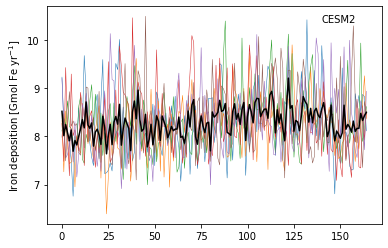

In [10]:
### TODO: uncomment iron_flux_glb1 plots when we can read that data

plot_name = f'timeseries.global.IRON_FLUX.pdf'

fig = plt.figure()
ax = fig.add_subplot(111)
for i in iron_flux_glb2.member_id.values:
    ax.plot(iron_flux_glb2.time, iron_flux_glb2.sel(member_id=i), linewidth=0.5)

ax.plot(iron_flux_glb2.time, iron_flux_glb2.mean('member_id'), color='k', linewidth=1.5)    

#ax.plot(iron_flux_glb1.time, iron_flux_glb1, linestyle='--', color='k', linewidth=1.5)    

ax.set_ylabel('Iron deposition [Gmol Fe yr$^{-1}$]');

# Need to get to the bottom of comment in cell [9] (why did we lose cftime in IRON_FLUX?)
#ax.text(cftime.DatetimeNoLeap(1990, 1, 1), iron_flux_glb2.sel(time='1990').max('member_id')*1.05, 'CESM2',color='k');
ax.text(140, iron_flux_glb2.isel(time=140).max('member_id')*1.05, 'CESM2',color='k');

#ax.text(cftime.DatetimeNoLeap(1965, 1, 1), iron_flux_glb1.sel(time='1960')*1.02, 'CESM1',color='k');

#plt.savefig(plot_name,dpi=300,bbox_inches='tight')

In [11]:
mmolm2s_to_molm2yr = 1e-3 * 86400. * 365.
iron_flux_map2 = ds2_ann.IRON_FLUX.isel(time=slice(145, 164)).mean(['time', 'member_id'])
iron_flux_map2 = iron_flux_map2.compute() * mmolm2s_to_molm2yr
iron_flux_map2

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'IRON_FLUX' (nlat: 384, nlon: 320)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [3.60231872e-08, 3.30332275e-08, 3.19513715e-08, ...,
                   nan,            nan,            nan],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Dimensions without coordinates: nlat, nlon

In [ ]:
iron_flux_map2

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


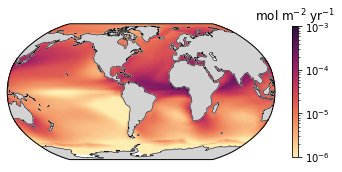

In [12]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))


pc = ax.pcolormesh(ds2.TLONG, ds2.TLAT, iron_flux_map2,
                   norm=colors.LogNorm(vmin=1e-6, vmax=1e-3),
                   cmap=cmocean.cm.matter,
                   transform=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                                   edgecolor='face',
                                                   facecolor='lightgray'))
ax.set_global() 
ax.coastlines(linewidth=0.5)
cb = plt.colorbar(pc, shrink=0.6)
cb.ax.set_title('mol m$^{-2}$ yr$^{-1}$');

In [13]:
iron_flux_map2.max()

<xarray.DataArray 'IRON_FLUX' ()>
array(0.00104778)

In [ ]:
cesm2.search(experiment=['historical', 'SSP5-8.5'], variable='IRON_FLUX').to_xarray(chunks={'time': 48})